# Report Execution Information on Different cluster Machines

This notebook benchmarks the **Harpia module**, the backend engine for Annotat3d, and similar frameworks on three machines from CNPEM cluster: Mary, Aida and Harriet.


## Framework

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


In [112]:
def filter_dataframe(df, filters):
    """
    Filters the DataFrame based on the specified filters.

    Parameters:
    - df (pd.DataFrame): The DataFrame to filter.
    - filters (dict): A dictionary where the key is the column name and the value is the value to filter by.

    Returns:
    - pd.DataFrame: The filtered DataFrame (original remains unchanged).
    """
    filtered_df = df.copy()
    for col, value in filters.items():
        filtered_df = filtered_df[filtered_df[col] == value]
    return filtered_df


In [90]:
def read_csv_files(path):
    """
    Reads all .csv (or .cs named as CSV) files from a folder and combines them into one DataFrame.
    Adds an 'exp' column indicating the source file index.
    
    Parameters:
        folder_path (str): Folder containing the CSV files.
        delimiter (str): Delimiter used in the CSV files (default is comma).
        
    Returns:
        pd.DataFrame: Combined DataFrame with 'exp' column.
    """
    all_data = []

    csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
    csv_files.sort()  # Optional for consistency

    for idx, file in enumerate(csv_files):
        df = pd.read_csv(file)
        df['exp'] = idx  # Tag rows with the file number
        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

In [91]:
def clean_framework_df(df, framework_name, min_input_size=0, min_input_mem=0):
    # Base columns common to all
    base_cols = ['Operation', 'Machine', 'Gpus', 'gpuMemory', 'Repetitions',
                 'Image Data Type', 'Image Size (MiB)', 'Image Dimensions', 'exp']

    # Framework-specific time and GPU memory columns
    time_col_map = {
        'skimage': 'Scikit Time (s)',
        'harpia': 'Harpia Time (s)',
        'cucim': 'Cucim Total Time (s)'
    }

    gpu_cols_map = {
        'skimage': ['skimage_gpu0(MiB)', 'skimage_gpu1(MiB)', 'skimage_gpu2(MiB)'],
        'harpia':  ['harpia_gpu0(MiB)', 'harpia_gpu1(MiB)', 'harpia_gpu2(MiB)'],
        'cucim':   ['cucim_gpu0(MiB)',  'cucim_gpu1(MiB)',  'cucim_gpu2(MiB)']
    }

    # Always select the base and total time column
    selected_cols = base_cols + [time_col_map[framework_name]] + gpu_cols_map[framework_name]

    # Add cucim-specific extra time columns
    if framework_name == 'cucim':
        selected_cols += ['Cucim Memory Time (s)', 'Cucim Gpu Time (s)']

    df_clean = df[selected_cols].copy()

    # Rename main time column to unified name
    df_clean.rename(columns={time_col_map[framework_name]: 'Total Time (s)'}, inplace=True)

    # Rename GPU0 to GPU Before
    df_clean.rename(columns={gpu_cols_map[framework_name][0]: 'GPU Before (MiB)'}, inplace=True)

    if framework_name == 'cucim':
        df_clean.rename(columns={'Cucim Memory Time (s)': 'Memory Time (s)'}, inplace=True)
        df_clean.rename(columns={'Cucim Gpu Time (s)': 'Gpu Time (s)'}, inplace=True)
    
    # Calculate GPU Max from GPU1 and GPU2
    gpu1_col = gpu_cols_map[framework_name][1]
    gpu2_col = gpu_cols_map[framework_name][2]
    df_clean['GPU Max (MiB)'] = df_clean[gpu1_col].combine(df_clean[gpu2_col], func=max)

    # Drop original GPU1 and GPU2 columns
    df_clean.drop(columns=[gpu1_col, gpu2_col], inplace=True)

    # Set GPU memory columns to NaN if framework is skimage or image size <= 1000
    memory_mask = (framework_name == 'skimage') | (df_clean['Image Size (MiB)'] <= min_input_mem)
    df_clean.loc[memory_mask, ['GPU Before (MiB)', 'GPU Max (MiB)']] = float('nan')

    # Drop rows where all performance metrics are NaN
    df_clean.dropna(
        subset=['Total Time (s)', 'GPU Before (MiB)', 'GPU Max (MiB)'],
        how='all',
        inplace=True
    )

    # Drop rows with image size ≤ min_input_size
    df_clean = df_clean[df_clean['Image Size (MiB)'] > min_input_size]

    # Add framework column
    framework_name_map = {
        "harpia": "Harpia",
        "cucim": "cuCIM",
        "skimage": "scikit-image"
    }
    df_clean['Framework'] = framework_name_map[framework_name]

    return df_clean


In [92]:
def print_unique_values(df, columns):
    for col in columns:
        if col in df.columns:
            unique_vals = df[col].unique()
            print(f"\nColumn: {col}")
            print(f"Unique values ({len(unique_vals)}): {unique_vals}")
        else:
            print(f"\nColumn: {col} not found in DataFrame.")


## Read data

In [213]:
current_dir = os.getcwd()
df_aida_new = read_csv_files(current_dir+"/results_aida_new/") 
df_aida = read_csv_files(current_dir+"/results_aida/cython/")
df_mary = read_csv_files(current_dir+"/results_mary/")

## Save Results

In [214]:
notebook_name = "comp_report_new"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: comp_report_new_plots


Removi tamanho de imagem pequneo demais, não havia dads significativos do scikit-image. Os dados da harriet não são muito confiáveis, eles trazem a média, mas não o desvio padrão. Difícil usá-los apra comparar com outras máquinas assim. Só tem os dados da Harpia também, não tem resultados do cuCIM

## Resulatdos: Mary e Aida

Todos os dados da Mary foram calculados só para 1 GPU e para imagens de 32bits (float32 ou int32), tem dados do scikit, harpia e cuCIM e uma repetição por função. Os valores de memória não são relevantes apra essa análise. E os valores do scikit não tem como serem comparados com os de outra máquina.

Todos os resultados da Aida foram calculados em apenas 1 gpu, para imagens de 32 bits (float32 ou int32). O cuCIM foi executado para vários tamanhos de imagem, a harpia só fio executada para o tamanho máximo de imagem (32GiB 2 2048 slices) e gpuMemory == 0.1

### Unite results

In [215]:
df_aida_harpia = clean_framework_df(df_aida, 'harpia')
df_aida_harpia.drop(columns=['Gpus', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

df_aida_cucim = clean_framework_df(df_aida, 'cucim')
df_aida_cucim.drop(columns=['Gpus', 'gpuMemory', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

#------------------------------------------------------------------------------------
df_mary_harpia = clean_framework_df(df_mary, 'harpia')
df_mary_harpia.drop(columns=['Repetitions','Gpus', 'Image Data Type', 'GPU Before (MiB)', 'GPU Max (MiB)'], inplace=True)

df_mary_cucim = clean_framework_df(df_mary, 'cucim')
df_mary_cucim.drop(columns=['Repetitions','Gpus', 'Image Data Type', 'GPU Before (MiB)', 'GPU Max (MiB)', 'gpuMemory'], inplace=True)
#------------------------------------------------------------------------------------

df_aida_new['Machine'] = df_aida_new['Machine'].replace('aida', 'aida_nova')

df_aida_new_harpia = clean_framework_df(df_aida_new, 'harpia')
df_aida_new_harpia.drop(columns=['Gpus', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

df_aida_new_cucim = clean_framework_df(df_aida_new, 'cucim')
df_aida_new_cucim.drop(columns=['Gpus', 'gpuMemory', 'Repetitions', 'Image Data Type', 'GPU Max (MiB)', 'GPU Before (MiB)'], inplace=True)

#------------------------------------------------------------------------------------
df_aida_mary = pd.concat([df_aida_harpia, df_aida_cucim, 
                          df_aida_new_harpia, df_aida_new_cucim, 
                          df_mary_harpia, df_mary_cucim], ignore_index=True)

# Filter out images smaller than 1 GiB
df_aida_mary = df_aida_mary[df_aida_mary['Image Size (MiB)'] >= 1000]
df_aida_mary['Image Size (GiB)'] = (df_aida_mary['Image Size (MiB)'] / 1024).round().astype(int)

df_aida_mary

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,exp,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...
39563,Dilation 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.203796,cuCIM,2.167192,0.036604,1
39564,Closing 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.192580,cuCIM,2.143896,0.048684,1
39565,Opening 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.224916,cuCIM,2.176298,0.048618,1
39566,Top Hat 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.196687,cuCIM,2.147981,0.048706,1


In [96]:
print_unique_values(df_aida_mary, df_aida_mary.columns)


Column: Operation
Unique values (22): ['Erosion 3D binary' 'Dilation 3D binary' 'Closing 3D binary'
 'Opening 3D binary' 'Smoothing 3D binary' 'Erosion 3D grayscale'
 'Dilation 3D grayscale' 'Closing 3D grayscale' 'Opening 3D grayscale'
 'Top Hat 3D grayscale' 'Bottom Hat 3D grayscale'
 'Gaussian Filter 3D grayscale' 'Mean Filter 3D grayscale'
 'Log Filter 3D grayscale' 'Unsharp Mask Filter 3D grayscale'
 'Sobel Filter 3D grayscale' 'Prewitt Filter 3D grayscale'
 'Anisotropic Diffusion Filter 3D grayscale' 'Threshold Niblack'
 'Threshold Sauvola' 'Threshold Mean' 'Threshold Gaussian']

Column: Machine
Unique values (3): ['aida' 'aida_nova' 'mary']

Column: gpuMemory
Unique values (3): [0.1   nan 0.05]

Column: Image Size (MiB)
Unique values (7): [32896.1  1028.  16448.1  2056.   4112.   8224.   3469.5]

Column: Image Dimensions
Unique values (7): ['(2048, 2052, 2052)' '(64, 2052, 2052)' '(1024, 2052, 2052)'
 '(128, 2052, 2052)' '(256, 2052, 2052)' '(512, 2052, 2052)'
 '(216, 2052, 205

In [216]:
# Define the filename and full path
csv_filename = "results_aida_mary.csv"
csv_path = os.path.join(output_dir, csv_filename)
df_aida_mary.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")
df_aida_mary

CSV saved to: comp_report_new_plots/results_aida_mary.csv


,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,exp,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...
39563,Dilation 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.203796,cuCIM,2.167192,0.036604,1
39564,Closing 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.192580,cuCIM,2.143896,0.048684,1
39565,Opening 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.224916,cuCIM,2.176298,0.048618,1
39566,Top Hat 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.196687,cuCIM,2.147981,0.048706,1


### Summarize Results

In [217]:
#filter out only one repetition operations
group_cols = ['Operation', 'Framework', 'Machine', 'Image Size (GiB)']

# Count how many times each group appears
group_counts = df_aida_mary.groupby(group_cols).size().reset_index(name='count')

# Keep only combos with more than 1 repetition
valid_groups = group_counts[group_counts['count'] > 1]

# Merge to filter original df
filtered_df = df_aida_mary.merge(valid_groups[group_cols], on=group_cols, how='inner')

In [218]:
def summarize_time_metrics(df):
    # Define the columns to summarize
    time_cols = ['Total Time (s)', 'Memory Time (s)', 'Gpu Time (s)']

    # Convert Image Size from MiB to GiB and round
    df = df.copy()  # Avoid modifying the original DataFrame

    # Group and calculate count, mean, std
    summary = (
        df
        .groupby(['Machine', 'Framework', 'Operation', 'Image Size (GiB)'])[time_cols]
        .agg(['count', 'mean', 'std'])
    )

    # Flatten column names
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    summary = summary.reset_index()

    # Add std percentage columns
    for col in time_cols:
        mean_col = f'{col}_mean'
        std_col = f'{col}_std'
        pct_col = f'{col}_std_%'
        summary[pct_col] = summary[std_col] / summary[mean_col] * 100

    return summary


In [219]:
df_summary= summarize_time_metrics(filtered_df)
df_summary

,Machine,Framework,Operation,Image Size (GiB),Total Time (s)_count,Total Time (s)_mean,Total Time (s)_std,Memory Time (s)_count,Memory Time (s)_mean,Memory Time (s)_std,Gpu Time (s)_count,Gpu Time (s)_mean,Gpu Time (s)_std,Total Time (s)_std_%,Memory Time (s)_std_%,Gpu Time (s)_std_%
0,aida,Harpia,Closing 3D binary,32,20,196.760220,107.437363,0,NaN,NaN,0,NaN,NaN,54.603193,NaN,NaN
1,aida,Harpia,Dilation 3D binary,32,20,176.768747,96.714479,0,NaN,NaN,0,NaN,NaN,54.712431,NaN,NaN
2,aida,Harpia,Erosion 3D binary,32,20,178.393145,106.589177,0,NaN,NaN,0,NaN,NaN,59.749592,NaN,NaN
3,aida,Harpia,Opening 3D binary,32,20,208.141426,83.916214,0,NaN,NaN,0,NaN,NaN,40.316921,NaN,NaN
4,aida,Harpia,Smoothing 3D binary,32,20,204.619380,97.986511,0,NaN,NaN,0,NaN,NaN,47.887210,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,mary,cuCIM,Threshold Sauvola,2,60,5.197642,0.104390,60,5.175037,0.104085,60,0.022605,0.033968,2.008404,2.011286,150.265780
427,mary,cuCIM,Top Hat 3D grayscale,1,77,2.207654,0.073944,77,2.158902,0.074095,77,0.048752,0.001604,3.349430,3.432072,3.291038
428,mary,cuCIM,Top Hat 3D grayscale,2,60,4.437380,0.117768,60,4.297383,0.110846,60,0.139998,0.052113,2.653994,2.579381,37.224241
429,mary,cuCIM,Top Hat 3D grayscale,4,60,8.851468,0.138981,60,8.621643,0.131916,60,0.229825,0.019381,1.570144,1.530058,8.433014


In [57]:
df_summary.columns

Index(['Machine', 'Framework', 'Operation', 'Image Size (GiB)',
       'Total Time (s)_count', 'Total Time (s)_mean', 'Total Time (s)_std',
       'Memory Time (s)_count', 'Memory Time (s)_mean', 'Memory Time (s)_std',
       'Gpu Time (s)_count', 'Gpu Time (s)_mean', 'Gpu Time (s)_std',
       'Total Time (s)_std_%', 'Memory Time (s)_std_%', 'Gpu Time (s)_std_%'],
      dtype='object')

In [220]:
csv_filename = "means_ainda_mary.csv"
csv_path = os.path.join(output_dir, csv_filename)
df_summary.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

CSV saved to: comp_report_new_plots/means_ainda_mary.csv


### Plot Standard Deviation Percentage

/tmp/ipykernel_3377371/97295896.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_general.png


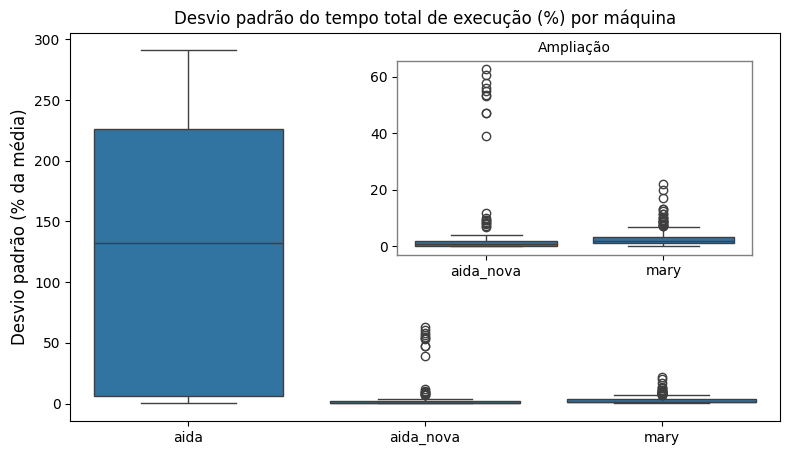

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Filter for 'mary' only
inset_df = df_summary[df_summary['Machine'].isin(['mary', 'aida_nova'])].copy()

# Main plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_summary, x='Machine', y='Total Time (s)_std_%', ax=ax)
ax.set_title('Desvio padrão do tempo total de execução (%) por máquina')
ax.set_ylabel('Desvio padrão (% da média)', fontsize=12)
ax.set_xlabel('')

# ➕ Add zoomed-in inset for mary
axins = inset_axes(ax, width="50%", height="50%", loc='upper right', borderpad=2)
sns.boxplot(data=inset_df, x='Machine', y='Total Time (s)_std_%', ax=axins)

# Clean inset
axins.set_title('Ampliação', fontsize=10)
axins.set_xlabel('')  # Remove x-axis label
axins.set_ylabel('')  # Remove x-axis label
#axins.set_xticklabels([])  # Remove x tick labels
#axins.set_ylabel('Desvio padrão (% da média)', fontsize=8)  # ✅ y-axis label
axins.tick_params(labelsize=10)
axins.grid(False)

# Optional: add a light border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

# Define output path
image_filename = f'time_boxplot_general.png'
image_path = os.path.join(output_dir, image_filename)

# Save figure BEFORE showing or closing
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
print(f"Imagem salva em: {image_path}")

# Then display if needed
plt.show()
plt.close()  # Optional, frees memory



/tmp/ipykernel_3377371/3895276127.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_general_cuCIM.png


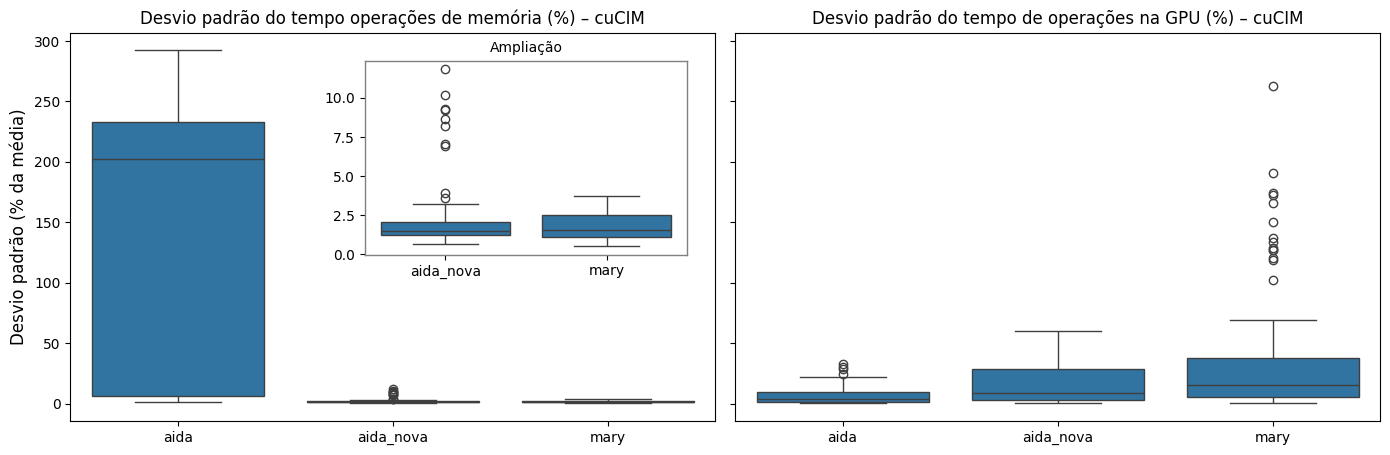

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Filter to only cuCIM framework
cucim_df = df_summary[df_summary['Framework'] == 'cuCIM'].copy()

# Set up two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Memory Time Std %
sns.boxplot(data=cucim_df, x='Machine', y='Memory Time (s)_std_%', ax=axes[0])
axes[0].set_title('Desvio padrão do tempo operações de memória (%) – cuCIM')
axes[0].set_xlabel('')
axes[0].set_ylabel('Desvio padrão (% da média)', fontsize=12)

# ➕ Inset zoom for 'mary'

inset_df = cucim_df[cucim_df['Machine'].isin(['mary', 'aida_nova'])].copy()
#mary_data = cucim_df[cucim_df['Machine'] == 'mary']
axins = inset_axes(axes[0], width="50%", height="50%", loc='upper right', borderpad=2)
sns.boxplot(data=inset_df, x='Machine', y='Memory Time (s)_std_%', ax=axins)

# Clean inset
axins.set_title('Ampliação', fontsize=10)
axins.set_xlabel('')                       # Remove x-axis label
axins.set_ylabel('')                       # Remove y-axis label
#axins.set_xticklabels([])                 # Remove x-tick label ('mary')
#axins.set_ylabel('Desvio padrão (% da média)', fontsize=8)  # Add y-axis label
axins.tick_params(labelsize=10)
axins.grid(False)

# Optional: light border for inset
for spine in axins.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)

# Plot 2: GPU Time Std %
sns.boxplot(data=cucim_df, x='Machine', y='Gpu Time (s)_std_%', ax=axes[1])
axes[1].set_title('Desvio padrão do tempo de operações na GPU (%) – cuCIM')
axes[1].set_xlabel('')

# Define output path
image_filename = f'time_boxplot_general_cuCIM.png'
image_path = os.path.join(output_dir, image_filename)

# Save figure BEFORE showing or closing
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
print(f"Imagem salva em: {image_path}")

# Then display if needed
plt.show()
plt.close()  # Optional, frees memory


### Plots: Boxplot - Execution Time by operation

In [224]:
df_aida_mary

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,exp,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB)
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,13.214981,Harpia,NaN,NaN,32
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,66.008873,Harpia,NaN,NaN,32
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,163.611486,Harpia,NaN,NaN,32
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,65.009234,Harpia,NaN,NaN,32
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,40.082520,Harpia,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...
39563,Dilation 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.203796,cuCIM,2.167192,0.036604,1
39564,Closing 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.192580,cuCIM,2.143896,0.048684,1
39565,Opening 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.224916,cuCIM,2.176298,0.048618,1
39566,Top Hat 3D grayscale,mary,NaN,1028.0,"(64, 2052, 2052)",107,2.196687,cuCIM,2.147981,0.048706,1


In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_execution_time_boxplot(
    df,
    operations,
    image_size_gib,
    framework,
    time_column='Total Time (s)'
):
    """
    Cria um boxplot de tempo de execução por Máquina, com zoom para 'mary'.

    Parâmetros:
    - df: DataFrame original com execuções individuais
    - operations: lista de operações a incluir (ex.: ['resize', 'rotate'])
    - image_size_gib: int, tamanho da imagem em GiB (arredondado de MiB)
    - framework: str, framework a filtrar (ex.: 'cuCIM' ou 'Harpia')
    - time_column: str, coluna de tempo a plotar (padrão: 'Total Time (s)')
    """
    
    # Cópia e conversão de tamanho
    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    # Filtrar dados
    df_filt = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Image Size (GiB)'] == image_size_gib) &
        (df_plot['Framework'] == framework)
    ].copy()

    if df_filt.empty:
        print(f"⚠️ Sem dados para: {framework}, {image_size_gib} GiB")
        return

    # Before plotting, define a consistent color palette for all machines present
    machines = df_filt['Machine'].unique()
    palette = dict(zip(
        machines,
        sns.color_palette('colorblind', n_colors=len(machines))
    ))
    
    # Plot principal
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)

    ax.set_title(
        f'Tempo de Execução por Máquina\n'
        f'Framework: {framework} • Tamanho: {image_size_gib} GiB\n'
        f'Operações: {", ".join(operations)}'
    )
    ax.set_xlabel('')
    ax.set_ylabel('Tempo (s)', fontsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)

    # 🔍 Inset zoom para 'mary'

    inset_df = df_filt[df_filt['Machine'].isin(['mary', 'aida_nova'])]
    axins = inset_axes(ax, width="50%", height="50%", loc='upper right', borderpad=2)
    sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)

    # Limpar inset
    axins.set_title('Ampliação', fontsize=10)
    axins.set_xlabel('')               # sem label no eixo x
    axins.set_ylabel('')               # sem label no eixo y
    #axins.set_xticklabels([])          # sem ticks no eixo x
    #axins.set_ylabel('Tempo (s)', fontsize=8)
    axins.tick_params(labelsize=10)
    axins.grid(False)

    # Borda leve no inset
    for spine in axins.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1)

    # Define output path
    image_filename = f'time_boxplot_{framework}_{operations[0]}_{image_size_gib}gib.png'
    image_path = os.path.join(output_dir, image_filename)

    # Save figure BEFORE showing or closing
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(image_path, dpi=300, bbox_inches='tight')  # Save first!
    print(f"Imagem salva em: {image_path}")
    
    # Then display if needed
    plt.show()
    plt.close()  # Optional, frees memory


/tmp/ipykernel_3377371/237414312.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)
/tmp/ipykernel_3377371/237414312.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)
/tmp/ipykernel_3377371/237414312.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_cuCIM_Dilation 3D grayscale_8gib.png


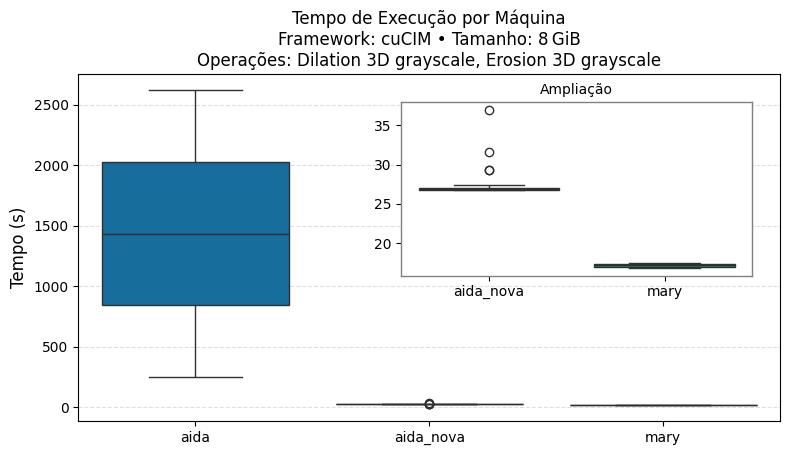

/tmp/ipykernel_3377371/237414312.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)
/tmp/ipykernel_3377371/237414312.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)
/tmp/ipykernel_3377371/237414312.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_Harpia_Dilation 3D grayscale_32gib.png


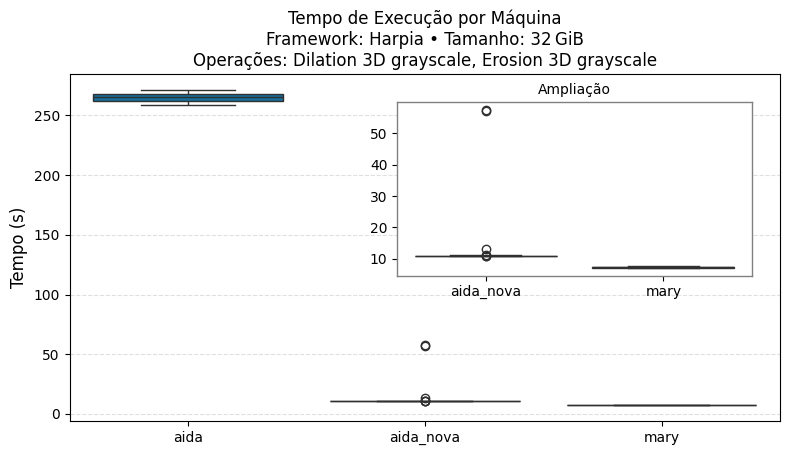

/tmp/ipykernel_3377371/237414312.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)
/tmp/ipykernel_3377371/237414312.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)
/tmp/ipykernel_3377371/237414312.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_cuCIM_Dilation 3D binary_8gib.png


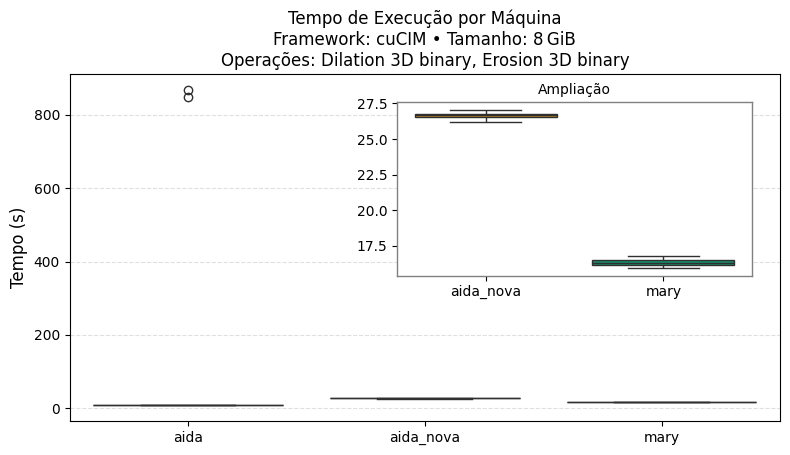

/tmp/ipykernel_3377371/237414312.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)
/tmp/ipykernel_3377371/237414312.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)
/tmp/ipykernel_3377371/237414312.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_Harpia_Dilation 3D binary_32gib.png


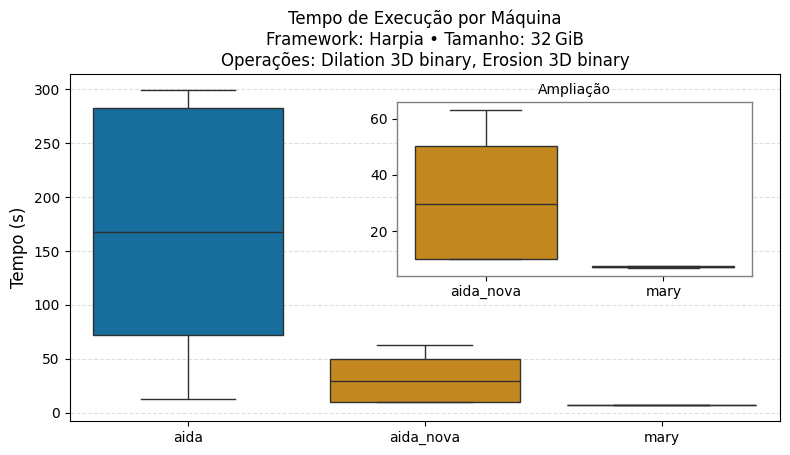

/tmp/ipykernel_3377371/237414312.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filt, x='Machine', y=time_column, palette=palette, ax=ax)
/tmp/ipykernel_3377371/237414312.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=inset_df, x='Machine', y=time_column, palette=palette, ax=axins)
/tmp/ipykernel_3377371/237414312.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.93])


Imagem salva em: comp_report_new_plots/time_boxplot_Harpia_Closing 3D binary_32gib.png


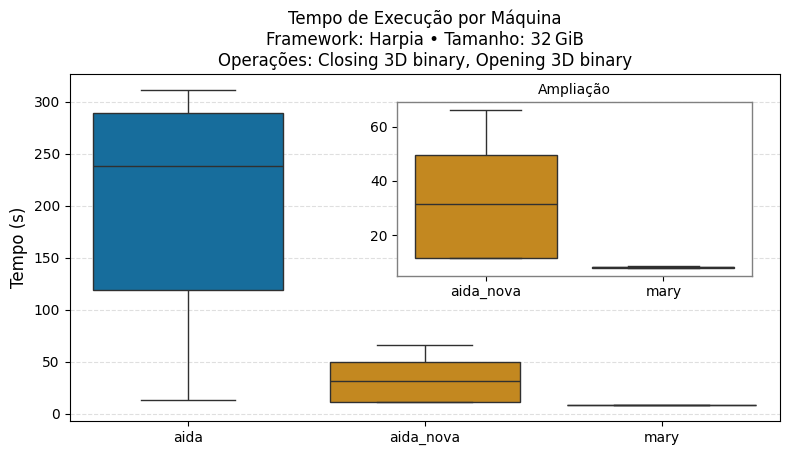

In [226]:
plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Dilation 3D grayscale', 'Erosion 3D grayscale'],
    image_size_gib=8,
    framework='cuCIM'
)

plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Dilation 3D grayscale', 'Erosion 3D grayscale'],
    image_size_gib=32,
    framework='Harpia'
)

plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Dilation 3D binary', 'Erosion 3D binary'],
    image_size_gib=8,
    framework='cuCIM'
)

plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Dilation 3D binary', 'Erosion 3D binary'],
    image_size_gib=32,
    framework='Harpia'
)

plot_execution_time_boxplot(
    df=df_aida_mary,
    operations=['Closing 3D binary', 'Opening 3D binary'],
    image_size_gib=32,
    framework='Harpia'
)

### Plots: Barplot - Min and Max Time by operation

#### framework

In [227]:
def filter_entries_with_enough_repeats_and_both_machines(df, n_machines):
    df = df.copy()
    df['Image Size (GiB)'] = (df['Image Size (MiB)'] / 1024).round().astype(int)

    # Count how many entries exist per combination
    group_counts = (
        df
        .groupby(['Operation', 'Image Size (GiB)', 'Framework', 'Machine'])
        .size()
        .reset_index(name='count')
    )

    # Keep only groups with at least 2 repetitions
    group_counts = group_counts[group_counts['count'] >= 2]

    # Count how many distinct machines have >=2 entries per (op, fw, size)
    machine_coverage = (
        group_counts
        .groupby(['Operation', 'Image Size (GiB)', 'Framework'])['Machine']
        .nunique()
        .reset_index(name='machine_count')
    )

    # Keep only those where n_machines (i.e., count == n_machines) are present
    valid_triples = machine_coverage[machine_coverage['machine_count'] == n_machines][
        ['Operation', 'Image Size (GiB)', 'Framework']
    ]

    # Merge with the original group_counts to get the valid (op, size, fw, machine) combos
    valid_groups = group_counts.merge(valid_triples, on=['Operation', 'Image Size (GiB)', 'Framework'])

    # Merge with the original df to keep only those entries
    df_filtered = df.merge(
        valid_groups[['Operation', 'Image Size (GiB)', 'Framework', 'Machine']],
        on=['Operation', 'Image Size (GiB)', 'Framework', 'Machine']
    )

    return df_filtered


In [228]:
from seaborn.palettes import color_palette
def plot_min_max_execution_times(
    df,
    summarize_df,
    operation_names_dict,
    framework,
    image_size_gib,
    output_dir,
    time_column='Total Time (s)',
    tag=''
):
    """
    Plots min, max, and std of execution times for given operations.

    Parameters:
    - df: raw DataFrame with execution times
    - summarize_df: summarized DataFrame (mean/std)
    - operation_names_dict: dict of {full op name: short name}
    - framework: framework name
    - image_size_gib: size in GiB
    - output_dir: where to save the plot
    - time_column: column used for timing
    - tag: optional suffix for image name
    """
    operations = list(operation_names_dict.keys())
    short_names = operation_names_dict

    df_plot = df.copy()
    df_plot['Image Size (GiB)'] = (df_plot['Image Size (MiB)'] / 1024).round().astype(int)

    df_filtered = df_plot[
        (df_plot['Operation'].isin(operations)) &
        (df_plot['Framework'] == framework) &
        (df_plot['Image Size (GiB)'] == image_size_gib)
    ].copy()

    if df_filtered.empty:
        print(f"⚠️ Sem dados para: {framework}, {image_size_gib} GiB")
        return

    is_binary = any("binary" in op.lower() for op in operations)
    op_type = "Binárias" if is_binary else "Grayscale"

    # Assign short operation names
    df_filtered['Operation Short'] = df_filtered['Operation'].map(short_names)

    # Count repetitions per machine
    num_ops = df_filtered['Operation Short'].nunique()
    counts_per_machine = (
        df_filtered
        .groupby('Machine')
        .size()
        .div(num_ops)
        .astype(int)
        .to_dict()
    )

    # Aggregate min/max stats
    stats = (
        df_filtered
        .groupby(['Operation Short', 'Machine'])[time_column]
        .agg(['min', 'max'])
        .reset_index()
    )

    # Set consistent category order
    short_ops = list(operation_names_dict.values())
    stats['Operation Short'] = pd.Categorical(stats['Operation Short'], categories=short_ops, ordered=True)

    # Prepare std data
    summarize_df = summarize_df.copy()
    if 'Image Size (GiB)' not in summarize_df.columns:
        summarize_df['Image Size (GiB)'] = (summarize_df['Image Size (MiB)'] / 1024).round().astype(int)

    summarize_df = summarize_df[
        (summarize_df['Framework'] == framework) &
        (summarize_df['Image Size (GiB)'] == image_size_gib) &
        (summarize_df['Operation'].isin(operations))
    ].copy()

    if summarize_df.empty:
        print("⚠️ Nenhum dado de desvio padrão encontrado para o terceiro gráfico.")
        return

    summarize_df['Operation Short'] = summarize_df['Operation'].map(short_names)
    summarize_df['Operation Short'] = pd.Categorical(summarize_df['Operation Short'], categories=short_ops, ordered=True)

    # Define color palettes
    machines_order = ['aida', 'aida_nova', 'mary']
    available_machines = [m for m in machines_order if m in df_filtered['Machine'].unique()]

    palettes = {
        'min': dict(zip(available_machines, color_palette("Blues", n_colors=len(available_machines)))),
        'max': dict(zip(available_machines, color_palette("Reds", n_colors=len(available_machines)))),
        'std': dict(zip(available_machines, color_palette("Greens", n_colors=len(available_machines)))),
    }

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1.2, 1.2, 1]})

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='min',
        hue='Machine',
        ax=axes[0],
        palette=palettes['min'],
        dodge=True
    )
    axes[0].set_title('Tempo de Execução Mínimo (s)')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')

    sns.barplot(
        data=stats,
        x='Operation Short',
        y='max',
        hue='Machine',
        ax=axes[1],
        palette=palettes['max'],
        dodge=True
    )
    axes[1].set_title('Tempo de Execução Máximo (s)')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')

    sns.barplot(
        data=summarize_df,
        x='Operation Short',
        y='Total Time (s)_std_%',
        hue='Machine',
        ax=axes[2],
        palette=palettes['std'],
        dodge=True
    )
    axes[2].set_title('Desvio Padrão (%) do Tempo Médio de Execução')
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')

    # Legend with n=
    machine_labels = {
        machine: f"{machine} (n={count})"
        for machine, count in counts_per_machine.items()
    }

    for ax in axes[:2]:
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [machine_labels.get(label, label) for label in labels]
        ax.legend(handles, new_labels, title="Máquina")

    axes[2].legend(title="Máquina")

    # Title and save
    fig.suptitle(
        f'Operações {op_type} — {framework} — {image_size_gib} GiB — Tempo Total (s)',
        fontsize=14
    )

    image_filename = f'min_max_std_barplot_{framework}_{operations[0]}_{image_size_gib}gib_std{tag}.png'
    image_path = os.path.join(output_dir, image_filename)

    plt.tight_layout(rect=[0, 0, 1, 0.93], w_pad=1)
    plt.savefig(image_path, dpi=300, bbox_inches='tight')
    print(f"📊 Imagem salva em: {image_path}")

    plt.show()
    plt.close()


#### Compare aida, aida_nova and mary

In [229]:
df_aida_mary_filtered = filter_entries_with_enough_repeats_and_both_machines(df_aida_mary, 3)

🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 2 GiB
⚠️ Sem dados para: harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 16 GiB
⚠️ Sem dados para: harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_1gib_std.png


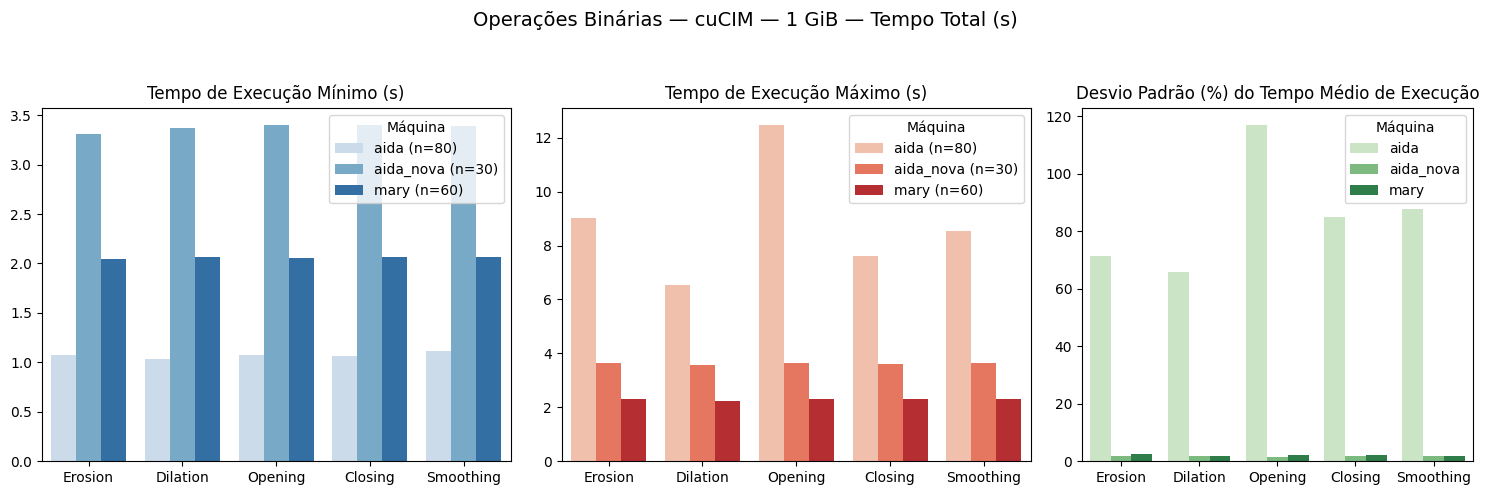

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_2gib_std.png


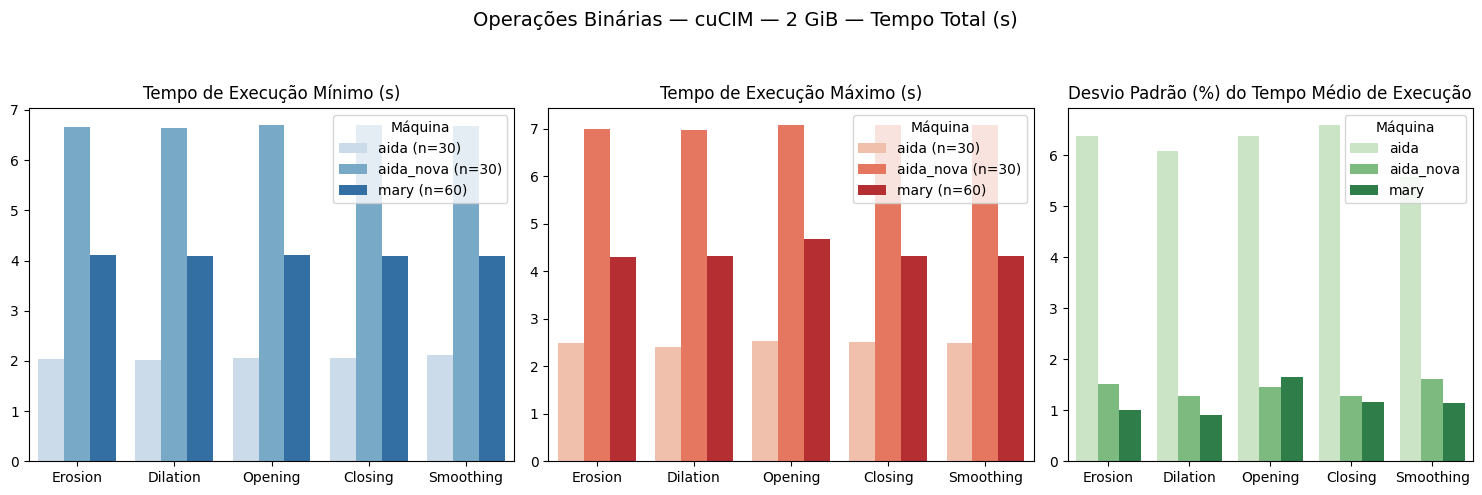

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 4 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_4gib_std.png


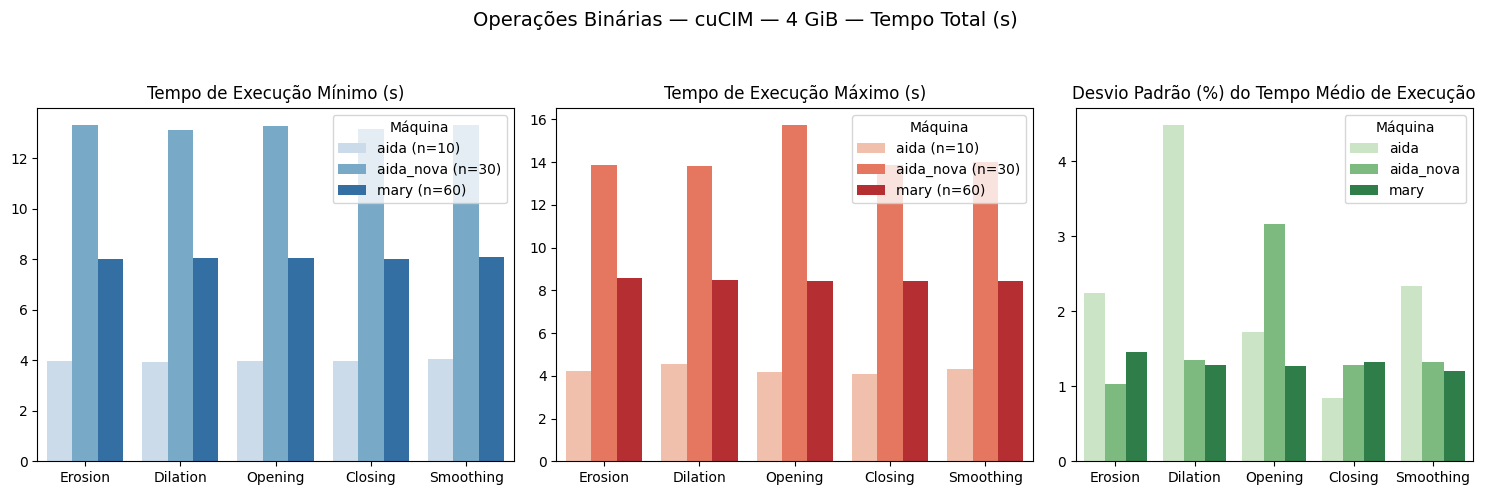

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 8 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_8gib_std.png


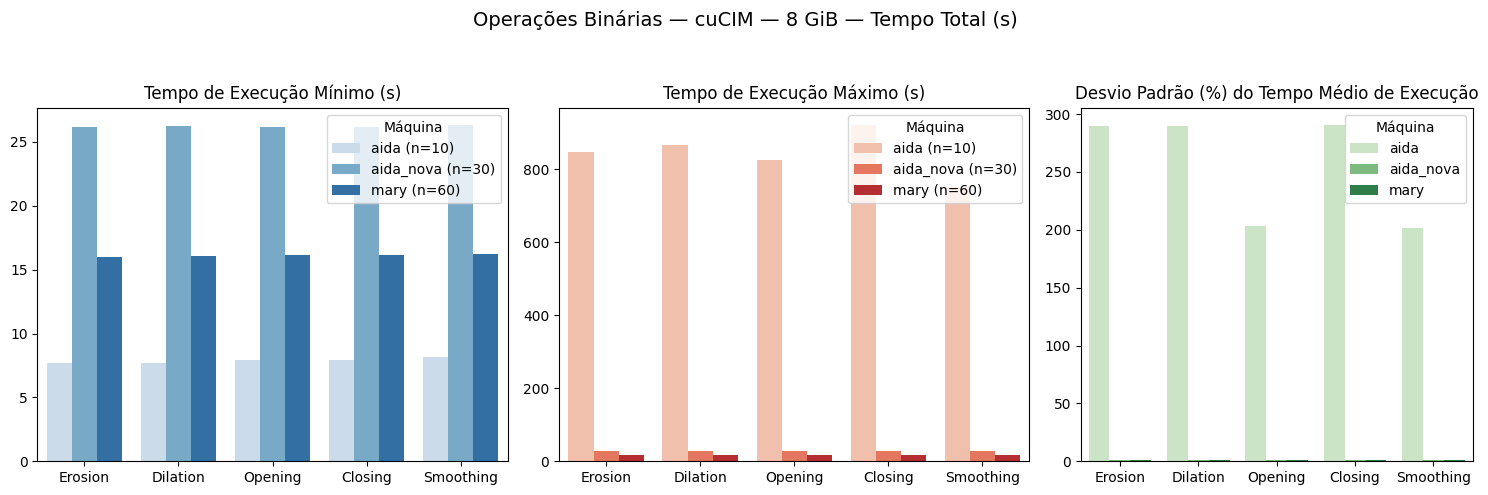

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 2 GiB
⚠️ Sem dados para: harpia, 2 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 16 GiB
⚠️ Sem dados para: harpia, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/m

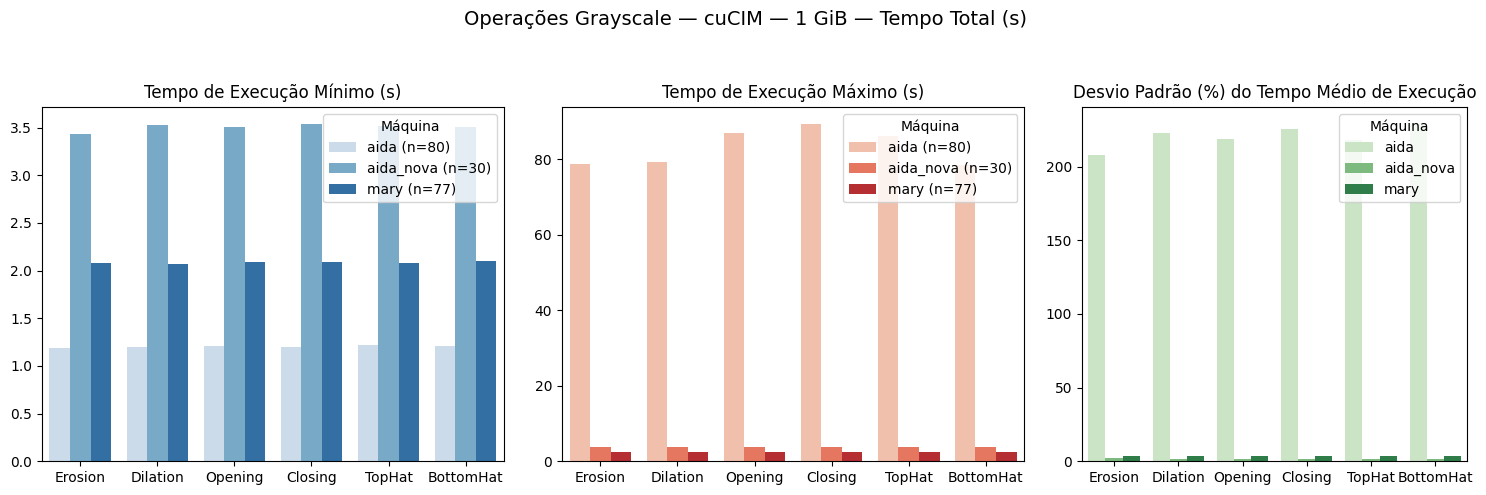

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D grayscale_2gib_std.png


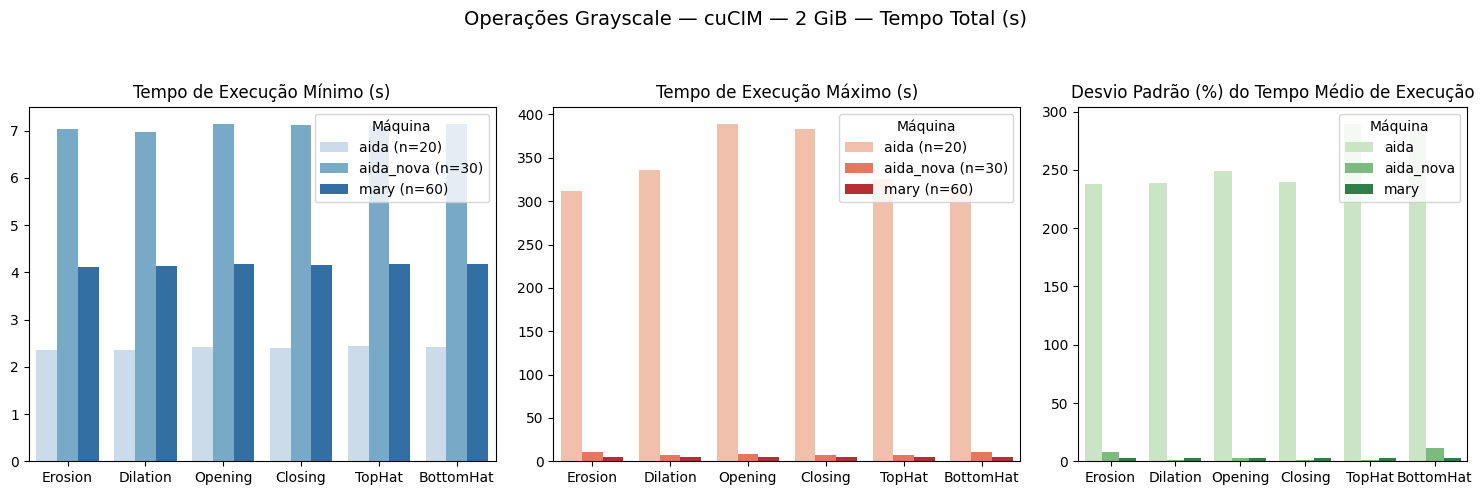

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 2 GiB
⚠️ Sem dados para: harpia, 2 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 16 GiB
⚠️ Sem dados para: harpia, 16 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 1 GiB

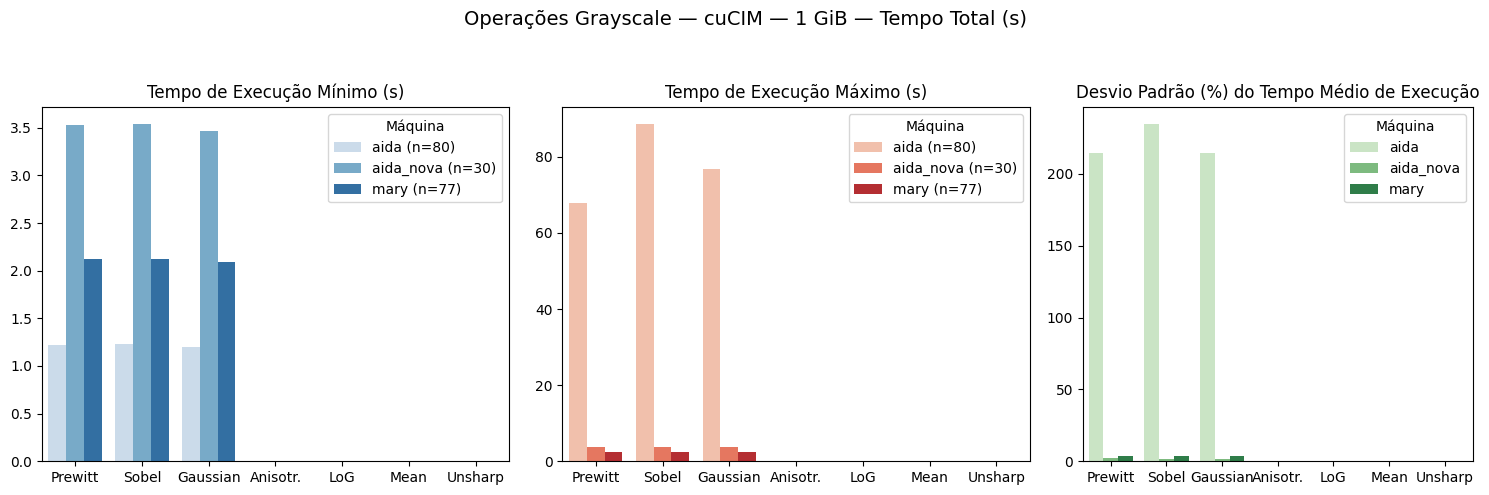

🔧 Plotting: Filtros, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Prewitt Filter 3D grayscale_2gib_std.png


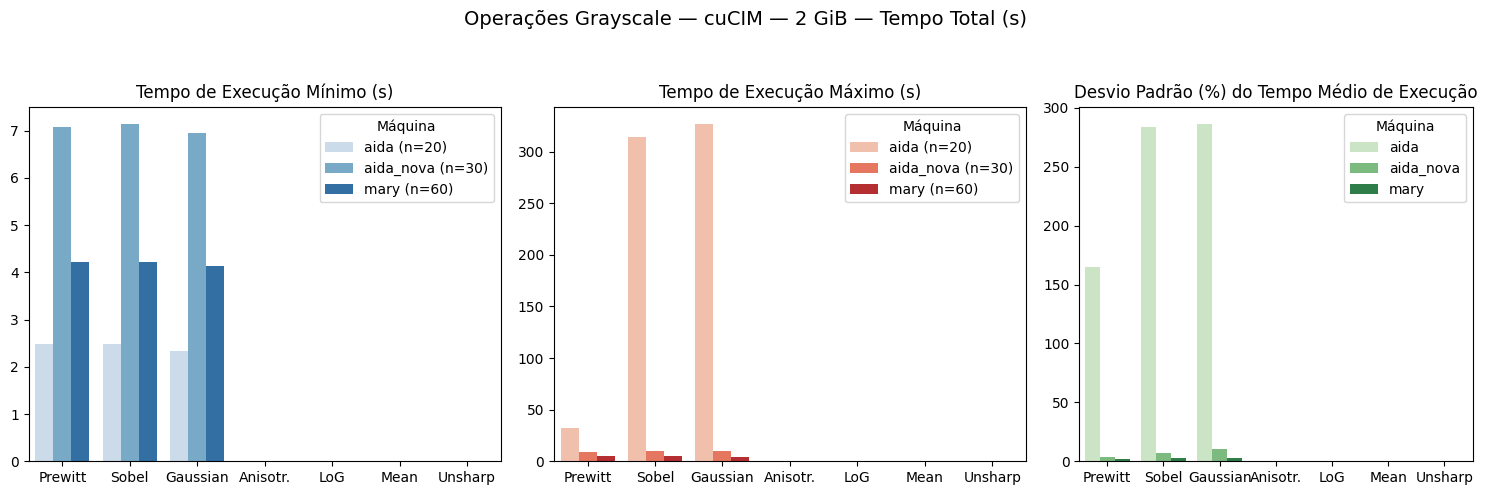

🔧 Plotting: Filtros, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 2 GiB
⚠️ Sem dados para: harpia, 2 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 16 GiB
⚠️ Sem dados para: harpia, 16 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Threshold Niblack_

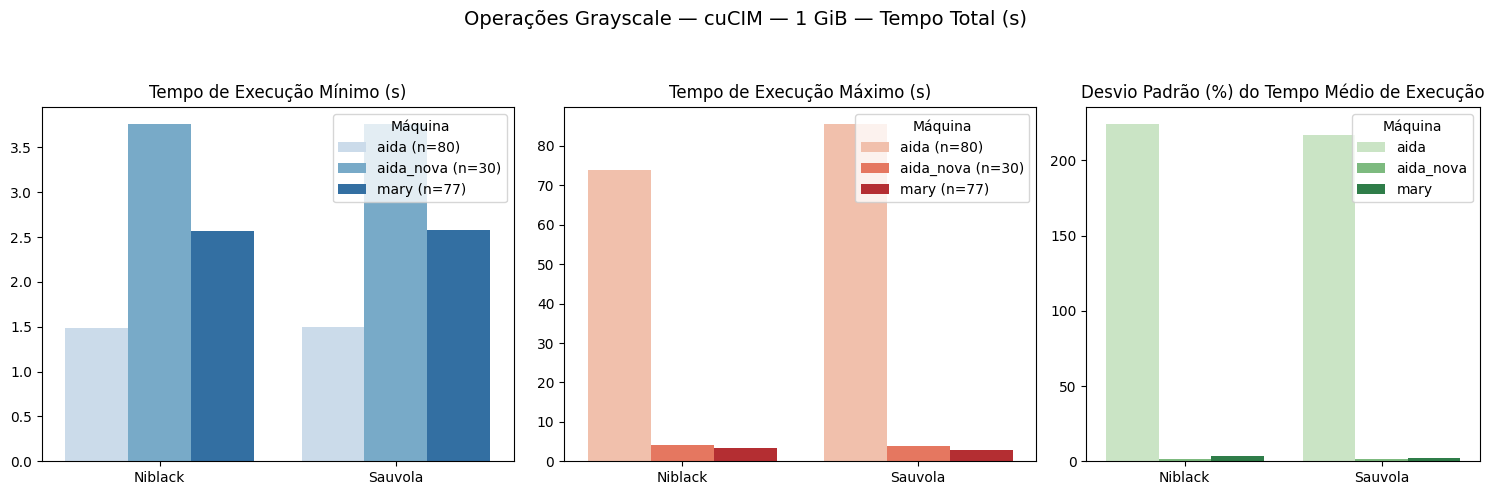

🔧 Plotting: Threshold, Framework: cuCIM, Size: 2 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Threshold Niblack_2gib_std.png


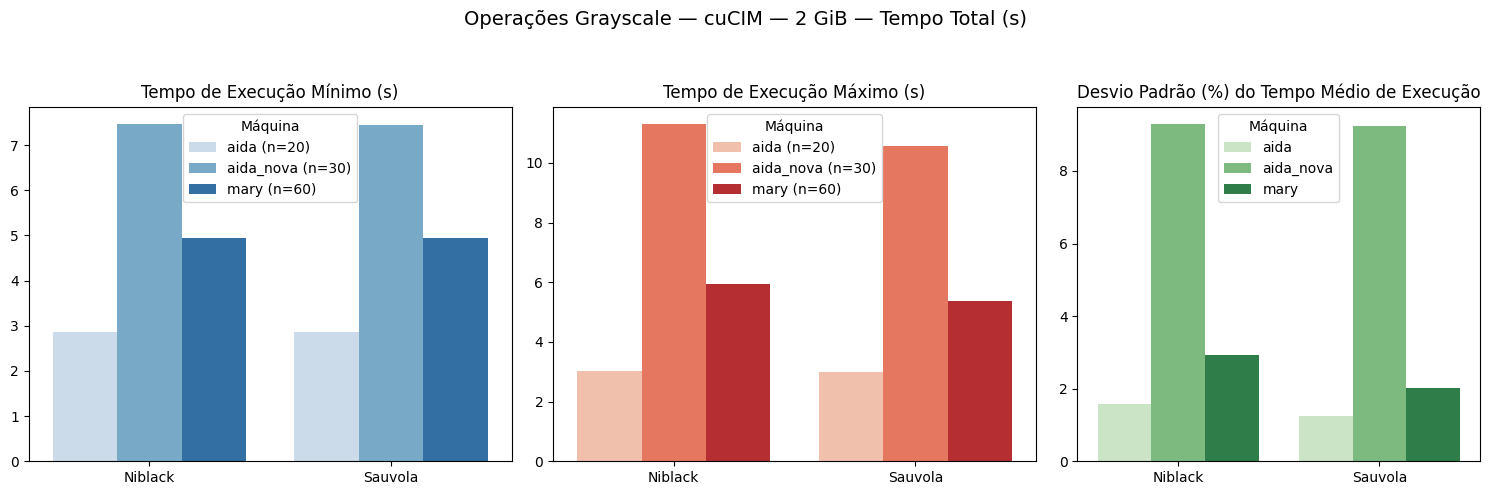

🔧 Plotting: Threshold, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 16 GiB
⚠️ Sem dados para: cuCIM, 16 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB


In [230]:
bianry_ops_dict = {
    'Erosion 3D binary': 'Erosion',
    'Dilation 3D binary': 'Dilation',
    'Opening 3D binary': 'Opening',
    'Closing 3D binary': 'Closing',
    'Smoothing 3D binary': 'Smoothing'
}
grayscale_ops_dict = {
    'Erosion 3D grayscale': 'Erosion',
    'Dilation 3D grayscale': 'Dilation',
    'Opening 3D grayscale': 'Opening',
    'Closing 3D grayscale': 'Closing',
    'Top Hat 3D grayscale': 'TopHat',
    'Bottom Hat 3D grayscale': 'BottomHat'
}
filter_ops_dict = {
    'Prewitt Filter 3D grayscale': 'Prewitt',
    'Sobel Filter 3D grayscale': 'Sobel',
    'Gaussian Filter 3D grayscale': 'Gaussian',
    'Anisotropic Diffusion Filter 3D grayscale': 'Anisotr.',
    'Log Filter 3D grayscale': 'LoG',
    'Mean Filter 3D grayscale': 'Mean',
    'Unsharp Mask Filter 3D grayscale': 'Unsharp'
}
threshold_ops_dict = {
    'Threshold Niblack': 'Niblack',
    'Threshold Sauvola': 'Sauvola',
}

operation_groups = [
    ("Operações Morfológicas Binárias", bianry_ops_dict),
    ("Operações Morfológicas Grayscale", grayscale_ops_dict),
    ("Filtros", filter_ops_dict),
    ("Threshold", threshold_ops_dict)
]
frameworks = ['harpia', 'cuCIM']
image_sizes_gib = [1,2,4,8,16,32]

for group_name, operations in operation_groups:
    for framework in frameworks:
        for size in image_sizes_gib:
            print(f'🔧 Plotting: {group_name}, Framework: {framework}, Size: {size} GiB')
            plot_min_max_execution_times(
                df=df_aida_mary_filtered,
                summarize_df=df_summary,
                operation_names_dict=operations,
                framework=framework,
                image_size_gib=size,
                output_dir=output_dir,
                time_column='Total Time (s)',
                tag='',
            )

#### Compare aida_nova and mary

In [231]:
df_aida_new_mary = df_aida_mary[df_aida_mary['Machine'].isin(['mary', 'aida_nova'])]
df_aida_new_mary_filtered = filter_entries_with_enough_repeats_and_both_machines(df_aida_new_mary, n_machines = 2)

df_summary_new = df_summary[df_summary['Machine'].isin(['mary', 'aida_nova'])]

🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_1gib_stdaida_new_mary.png


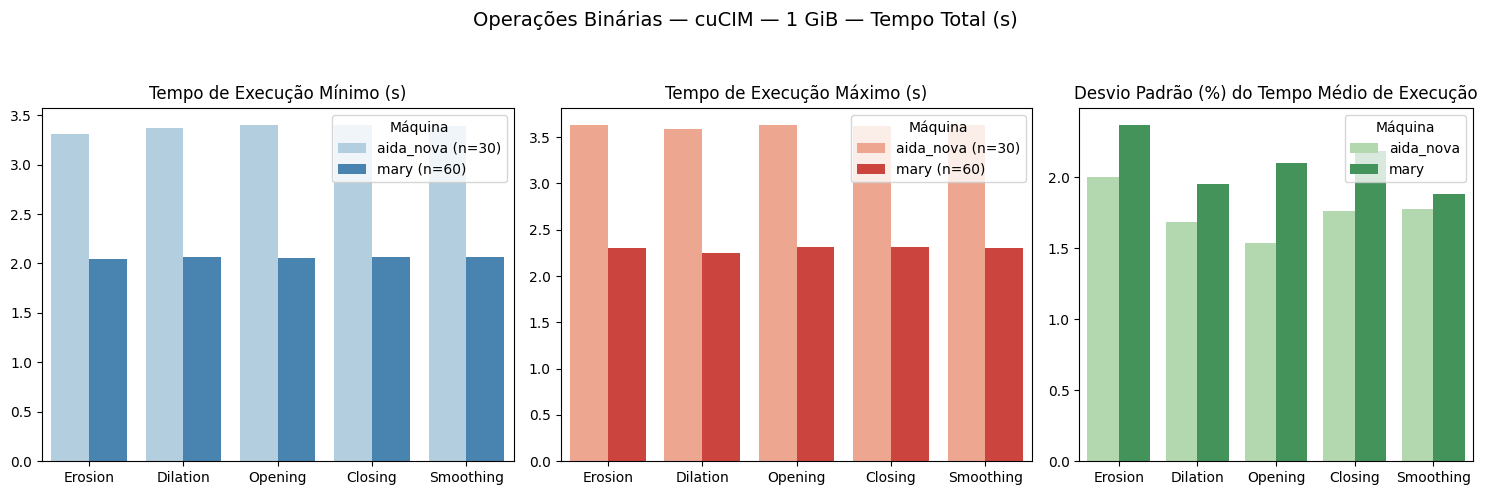

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 4 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_4gib_stdaida_new_mary.png


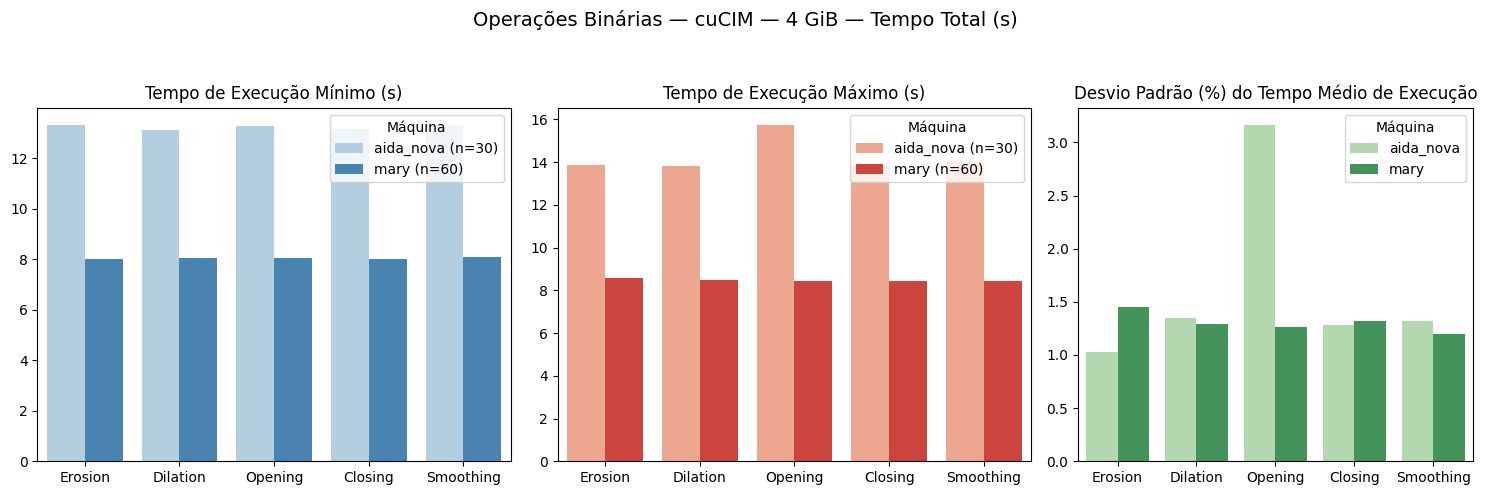

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 8 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D binary_8gib_stdaida_new_mary.png


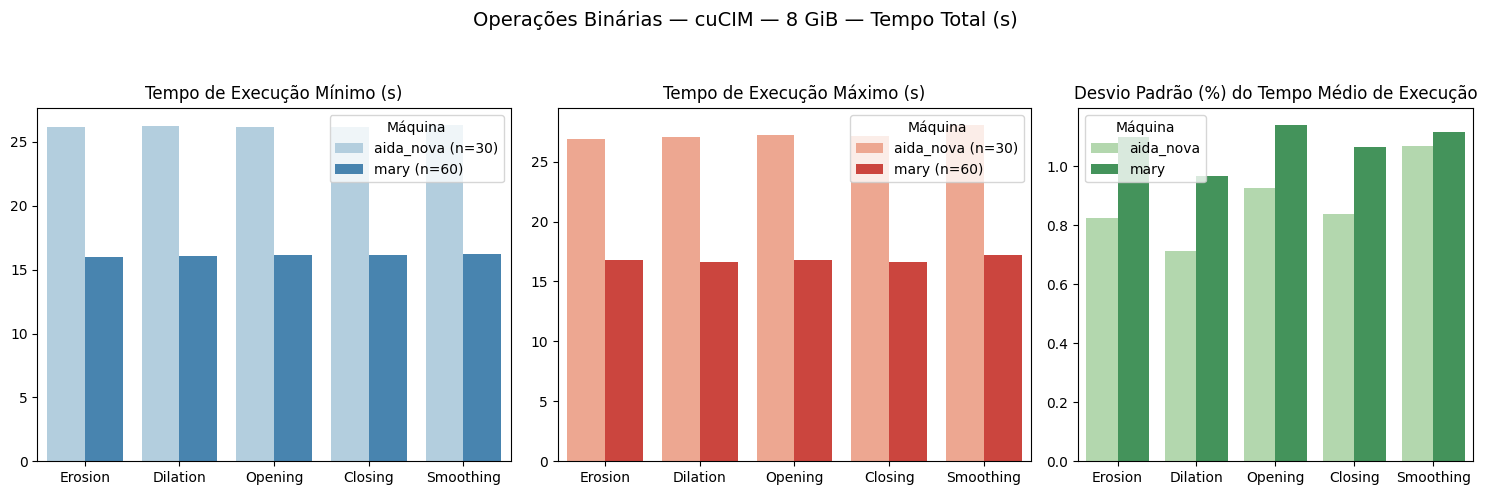

🔧 Plotting: Operações Morfológicas Binárias, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D grayscale_1gib_stdaida_new_mary.png


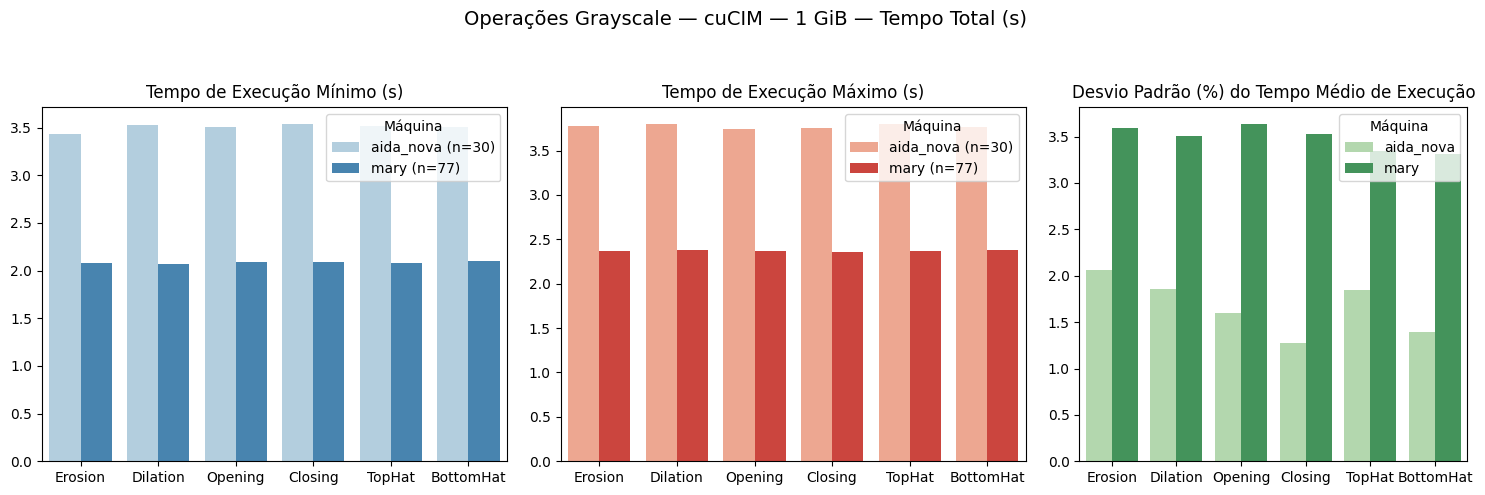

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 4 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D grayscale_4gib_stdaida_new_mary.png


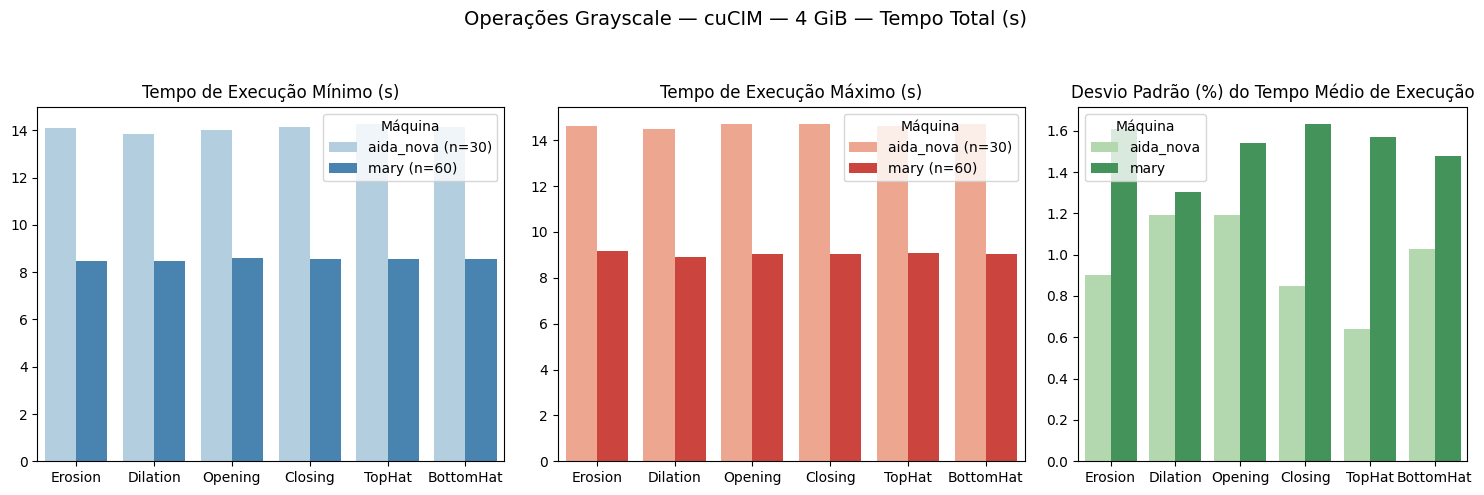

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 8 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Erosion 3D grayscale_8gib_stdaida_new_mary.png


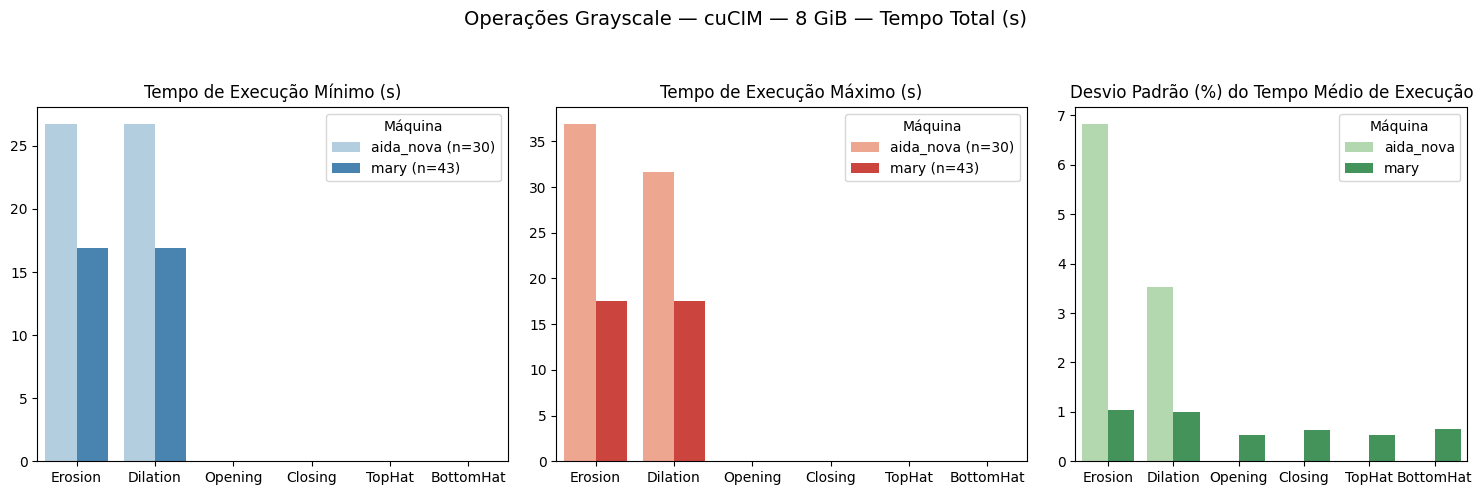

🔧 Plotting: Operações Morfológicas Grayscale, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Filtros, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Filtros, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Prewitt Filter 3D grayscale_1gib_stdaida_new_mary.png


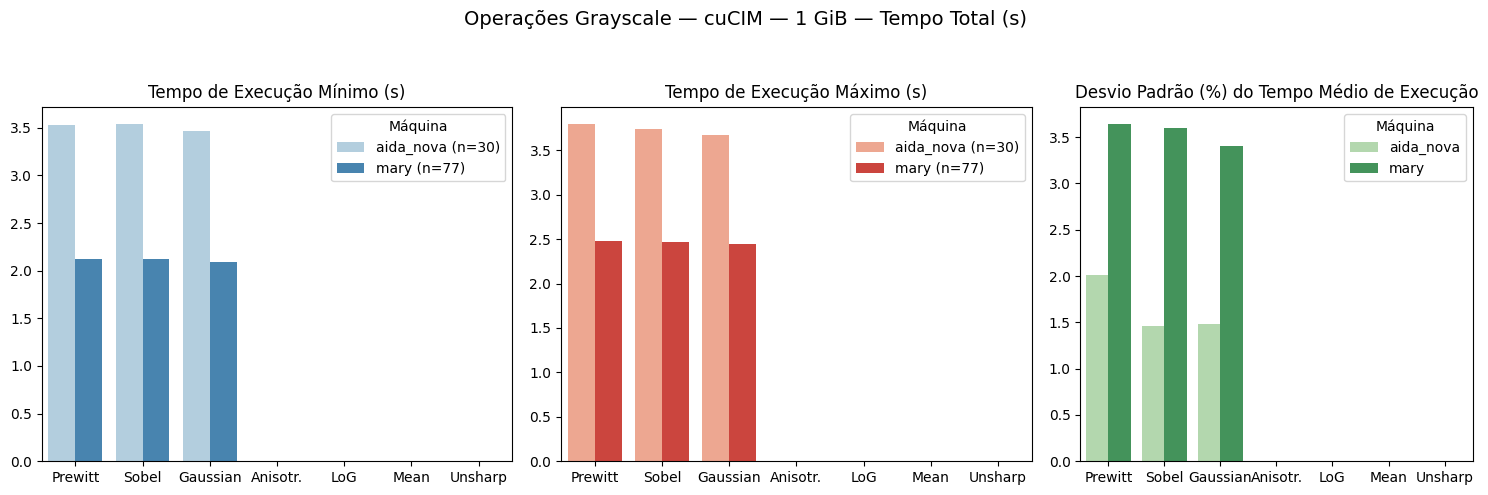

🔧 Plotting: Filtros, Framework: cuCIM, Size: 4 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Prewitt Filter 3D grayscale_4gib_stdaida_new_mary.png


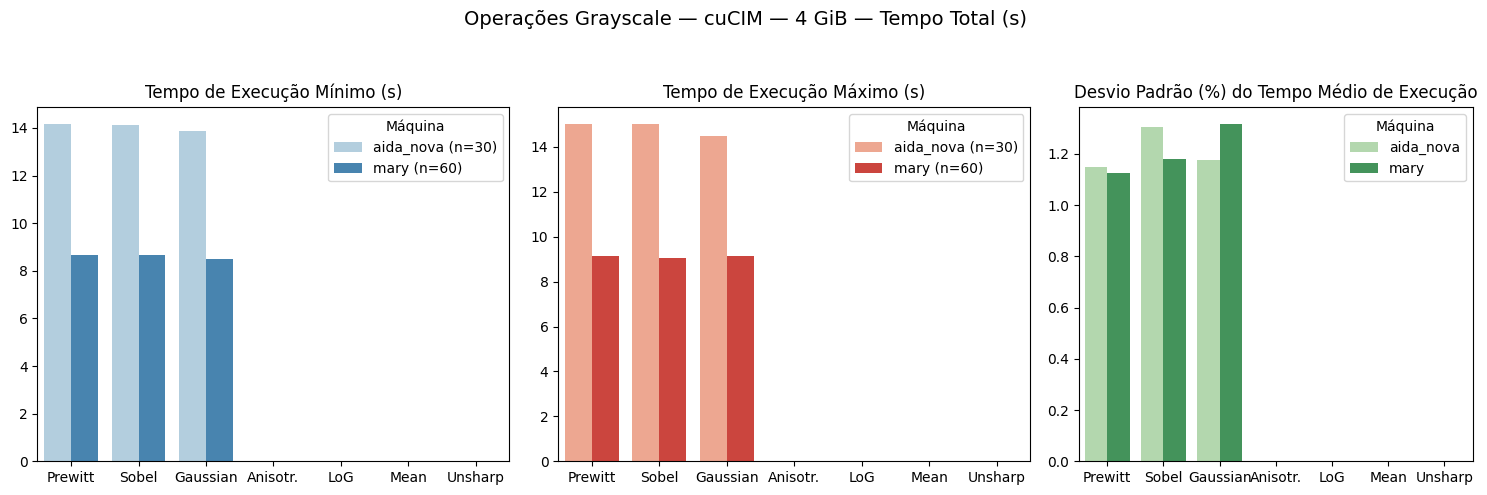

🔧 Plotting: Filtros, Framework: cuCIM, Size: 8 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Prewitt Filter 3D grayscale_8gib_stdaida_new_mary.png


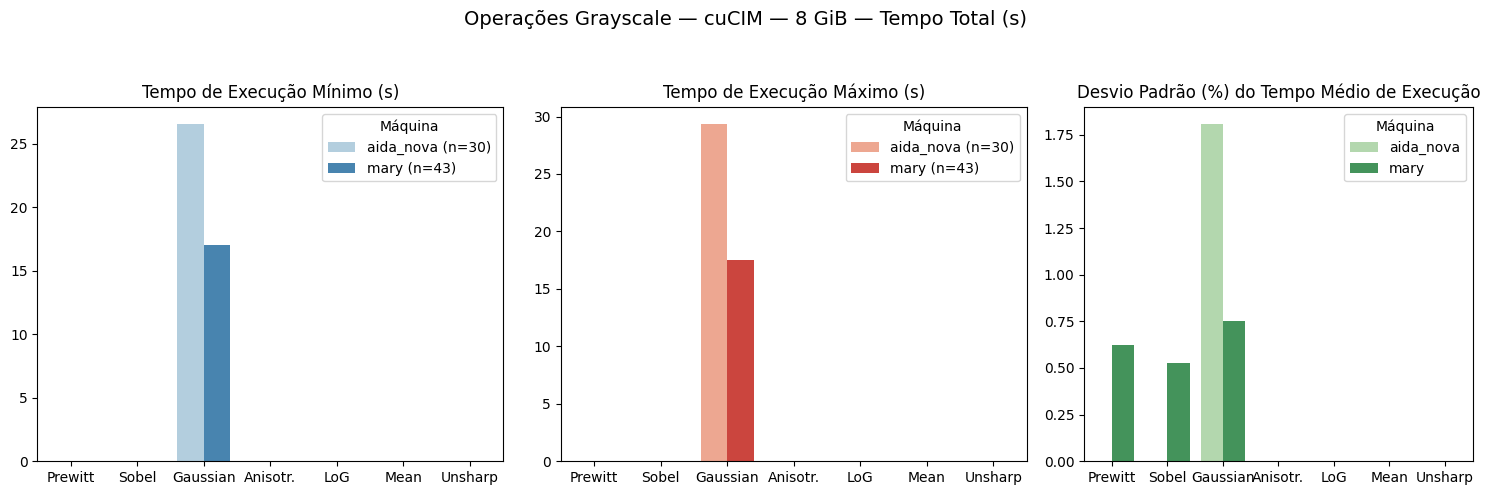

🔧 Plotting: Filtros, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 1 GiB
⚠️ Sem dados para: harpia, 1 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 4 GiB
⚠️ Sem dados para: harpia, 4 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 8 GiB
⚠️ Sem dados para: harpia, 8 GiB
🔧 Plotting: Threshold, Framework: harpia, Size: 32 GiB
⚠️ Sem dados para: harpia, 32 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 1 GiB
📊 Imagem salva em: comp_report_new_plots/min_max_std_barplot_cuCIM_Threshold Niblack_1gib_stdaida_new_mary.png


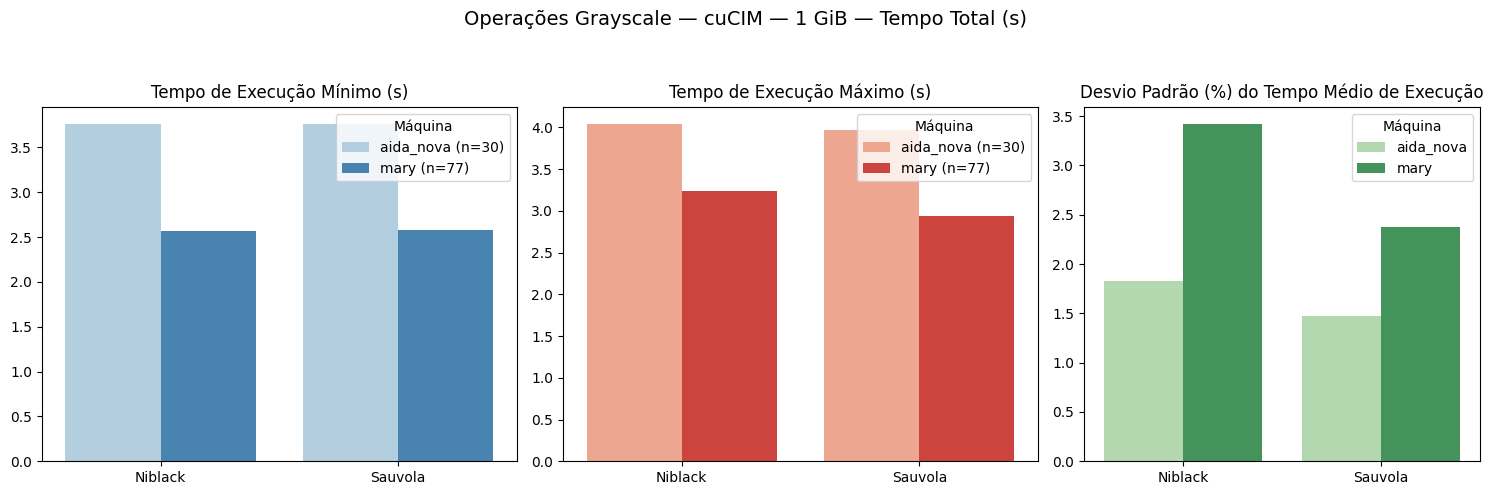

🔧 Plotting: Threshold, Framework: cuCIM, Size: 4 GiB
⚠️ Sem dados para: cuCIM, 4 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 8 GiB
⚠️ Sem dados para: cuCIM, 8 GiB
🔧 Plotting: Threshold, Framework: cuCIM, Size: 32 GiB
⚠️ Sem dados para: cuCIM, 32 GiB


In [232]:
operation_groups = [
    ("Operações Morfológicas Binárias", bianry_ops_dict),
    ("Operações Morfológicas Grayscale", grayscale_ops_dict),
    ("Filtros", filter_ops_dict),
    ("Threshold", threshold_ops_dict)
]

for group_name, operations in operation_groups:
    for framework in frameworks:
        #for size in image_sizes_gib:
        for size in [1, 4, 8, 32]:
            print(f'🔧 Plotting: {group_name}, Framework: {framework}, Size: {size} GiB')
            plot_min_max_execution_times(
                df=df_aida_new_mary_filtered,
                summarize_df=df_summary_new,
                operation_names_dict=operations,
                framework=framework,
                image_size_gib=size,
                output_dir=output_dir,
                time_column='Total Time (s)',
                tag='aida_new_mary',
            )

### Experiment lines

#### framework

In [233]:
def add_operation_counters(df, operation_col='Operation', exp_col='exp'):
    """
    Adds a 'time' column that counts each appearance of an operation per experiment.
    
    Parameters:
        df (pd.DataFrame): The combined DataFrame.
        operation_col (str): Column with operation names.
        exp_col (str): Column with experiment identifiers.
        
    Returns:
        pd.DataFrame: DataFrame with new 'time' column.
    """
    df = df.copy()
    df['time'] = df.groupby([exp_col, operation_col]).cumcount() + 1
    return df


In [234]:
def normalize_total_time(df):
    """
    Adds a 'Normalized Time' column by dividing 'Total Time (s)' by the
    minimum execution time for each group defined by:
    ['Operation', 'Machine', 'Image Size (MiB)', 'Image Dimensions', 'Framework'].
    
    Also returns whether all normalized values are >= 1.
    
    Parameters:
        df (pd.DataFrame): The original DataFrame.
        
    Returns:
        pd.DataFrame: New DataFrame with 'Normalized Time' column.
        bool: True if all normalized times are >= 1, False otherwise.
    """
    df = df.copy()

    group_cols = ['Operation', 'Machine', 'Image Size (GiB)', 'Image Dimensions', 'Framework']

    # Find minimum total time per group
    min_times = df.groupby(group_cols)['Total Time (s)'].transform('min')
    
    # Normalize
    df['Normalized Time'] = df['Total Time (s)'] / min_times

    # Sanity check: all values should be >= 1
    all_ge_one = (df['Normalized Time'] >= 1).all()

    return df, all_ge_one

In [250]:
def plot_normalized_time_single_machine(
    df, df_min_times, operation, framework, image_size_gib, machine, 
    save_dir, filename_prefix="plot", save_format="png"
):
    """
    Plot Normalized Time vs time for each experiment (exp) for a single specified machine.
    Legend shows exp and min time used for normalization.

    Parameters:
        df (pd.DataFrame): Normalized DataFrame.
        df_min_times (pd.DataFrame): Summary DataFrame with min times.
        operation (str): Operation name to filter.
        framework (str): Framework name to filter.
        image_size_gib (float): Image size in GiB to filter.
        machine (str): Machine name to filter ('aida' or 'aida_nova').
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    filtered_df = df[
        (df['Operation'] == operation) &
        (df['Machine'] == machine) &
        (df['Framework'] == framework) &
        (df['Image Size (GiB)'] == image_size_gib)
    ]
    
        # Se não houver dados, não criar plot
    if filtered_df.empty:
        print(f"⚠️ Nenhum dado encontrado para máquina '{machine}' com a combinação informada.")
        return  # Sai da função sem plotar

    min_times_machine = df_min_times[
        (df_min_times['Operation'] == operation) &
        (df_min_times['Machine'] == machine) &
        (df_min_times['Framework'] == framework) &
        (df_min_times['Image Size (GiB)'] == image_size_gib)
    ]
    
    if min_times_machine.empty:
        min_time_val = None
    else:
        min_time_val = min_times_machine['Min Total Time (s)'].values[0]
    
    for exp_id, group in filtered_df.groupby('exp'):
        label = f'exp {exp_id}'
        if min_time_val is not None:
            label += f' (tempo min={min_time_val:.3f}s)'
        ax.plot(group['time'], group['Normalized Time'], marker='o', label=label)
    
    min_time = int(filtered_df['time'].min())
    max_time = int(filtered_df['time'].max())
    
    range_span = max_time - min_time
    if range_span <= 10:
        step = 1
    elif range_span <= 20:
        step = 2
    else:
        step = 3
    
    time_ticks = np.arange(min_time, max_time + 1, step)
    ax.set_xticks(time_ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.set_title(f'Máquina: {machine}', fontsize=16)
    ax.set_xlabel('Índice da repetição', fontsize=13)
    ax.set_ylabel('Tempo de execução normalizado pelo mínimo', fontsize=13)
    ax.legend(title='Experimento', fontsize=11)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    plt.tight_layout()
    plt.show()

In [249]:
def plot_normalized_time_compare_machines(
    df, df_min_times, operation, framework, image_size_gib,
    save_dir, filename_prefix="plot", save_format="png"
):
    machines = ['aida', 'aida_nova']

    # Filter df by each machine
    filtered = {}
    for machine in machines:
        filtered[machine] = df[
            (df['Operation'] == operation) &
            (df['Machine'] == machine) &
            (df['Framework'] == framework) &
            (df['Image Size (GiB)'] == image_size_gib)
        ]

    # If both filtered datasets are empty, abort plotting
    if all(filtered[m].empty for m in machines):
        print("⚠️ Nenhum dado para ambas máquinas — não será gerado nenhum gráfico.")
        return

    # Determine how many subplots (1 or 2) based on existing data
    active = [m for m in machines if not filtered[m].empty]
    fig, axes = plt.subplots(1, len(active),
                             figsize=(7 * len(active), 6),
                             sharey=True)

    if len(active) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, machine in zip(axes, active):
        filtered_df = filtered[machine]
        min_times_machine = df_min_times[
            (df_min_times['Operation'] == operation) &
            (df_min_times['Machine'] == machine) &
            (df_min_times['Framework'] == framework) &
            (df_min_times['Image Size (GiB)'] == image_size_gib)
        ]
        min_time_val = (min_times_machine['Min Total Time (s)'].values[0]
                        if not min_times_machine.empty else None)

        for exp_id, group in filtered_df.groupby('exp'):
            label = f'exp {exp_id}'
            if min_time_val is not None:
                label += f' (min={min_time_val:.3f}s)'
            ax.plot(group['time'], group['Normalized Time'], marker='o', label=label, alpha=0.8)

        mx, Mx = int(filtered_df['time'].min()), int(filtered_df['time'].max())
        span = Mx - mx
        step = 1 if span <= 10 else (2 if span <= 20 else 3)
        ax.set_xticks(np.arange(mx, Mx + 1, step))
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.set_title(f'Máquina: {machine}', fontsize=16)
        ax.set_xlabel('Índice da repetição', fontsize=13)
        ax.set_ylabel('Tempo de execução normalizado pelo mínimo', fontsize=13)
        ax.legend(title='Experimento', fontsize=11)
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

    plt.suptitle(f'Op: {operation}, Framework: {framework}, Imagem: {image_size_gib} GiB', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Cria diretório se necessário
    os.makedirs(save_dir, exist_ok=True)
    # Define nome de arquivo
    fname = f"{filename_prefix}_{operation}_{framework}_{image_size_gib}GiB.{save_format}"
    filepath = os.path.join(save_dir, fname)
    fig.savefig(filepath)
    print(f"📌 Gráfico salvo em: {filepath}")
    plt.close(fig)


#### Tempos mínimos

In [237]:
df_times = add_operation_counters(df_aida_mary)

In [238]:
# Supondo que df_times seja o seu DataFrame original
group_cols = ['Operation', 'Machine', 'Image Size (GiB)', 'Image Dimensions', 'Framework']

# Agrupar por múltiplas colunas e calcular o mínimo e máximo de 'Total Time (s)'
df_min_max_times = df_times.groupby(group_cols)['Total Time (s)'].agg(['min', 'max']).reset_index()

# Renomear as colunas para maior clareza
df_min_max_times.columns = group_cols + ['Min Total Time (s)', 'Max Total Time (s)']

df_min_max_times

,Operation,Machine,Image Size (GiB),Image Dimensions,Framework,Min Total Time (s),Max Total Time (s)
0,Anisotropic Diffusion Filter 3D grayscale,aida,32,"(2048, 2052, 2052)",Harpia,328.852885,328.852885
1,Anisotropic Diffusion Filter 3D grayscale,aida_nova,1,"(64, 2052, 2052)",Harpia,0.702836,0.737770
2,Anisotropic Diffusion Filter 3D grayscale,aida_nova,2,"(128, 2052, 2052)",Harpia,1.413445,1.452103
3,Anisotropic Diffusion Filter 3D grayscale,aida_nova,4,"(256, 2052, 2052)",Harpia,2.805159,3.008150
4,Anisotropic Diffusion Filter 3D grayscale,aida_nova,8,"(512, 2052, 2052)",Harpia,5.568329,5.617414
...,...,...,...,...,...,...,...
453,Unsharp Mask Filter 3D grayscale,mary,2,"(128, 2052, 2052)",Harpia,3.590069,3.718712
454,Unsharp Mask Filter 3D grayscale,mary,3,"(216, 2052, 2052)",Harpia,6.176217,6.426194
455,Unsharp Mask Filter 3D grayscale,mary,8,"(512, 2052, 2052)",Harpia,20.681592,20.872123
456,Unsharp Mask Filter 3D grayscale,mary,16,"(1024, 2052, 2052)",Harpia,43.391134,43.789930


In [239]:
df = filter_dataframe(df_min_max_times, {'Framework':'cuCIM', 'Image Size (GiB)': 2, 'Machine': 'aida'})
df

,Operation,Machine,Image Size (GiB),Image Dimensions,Framework,Min Total Time (s),Max Total Time (s)
14,Bottom Hat 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.428861,312.259668
37,Closing 3D binary,aida,2,"(128, 2052, 2052)",cuCIM,2.055135,2.509832
64,Closing 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.402407,383.037362
87,Dilation 3D binary,aida,2,"(128, 2052, 2052)",cuCIM,2.016169,2.416922
114,Dilation 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.357131,336.482141
139,Erosion 3D binary,aida,2,"(128, 2052, 2052)",cuCIM,2.035489,2.492757
166,Erosion 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.349125,312.200182
191,Gaussian Filter 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.335808,326.993454
241,Opening 3D binary,aida,2,"(128, 2052, 2052)",cuCIM,2.063188,2.530139
268,Opening 3D grayscale,aida,2,"(128, 2052, 2052)",cuCIM,2.422629,389.353800


#### Normalização

In [240]:
df = filter_dataframe(df_normalized, {'Framework':'cuCIM', 'Image Size (GiB)': 2, 'Machine': 'aida'})
df

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,exp,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB),time,Normalized Time
486,Erosion 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",3,2.048901,cuCIM,1.968584,0.080317,2,1,1.006589
487,Dilation 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",3,2.285622,cuCIM,2.206677,0.078945,2,1,1.133646
488,Closing 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",3,2.348406,cuCIM,2.236382,0.112024,2,1,1.142701
489,Opening 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",3,2.530139,cuCIM,2.460334,0.069805,2,1,1.226325
490,Smoothing 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",3,2.495270,cuCIM,2.395944,0.099326,2,1,1.176445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,Smoothing 3D binary,aida,NaN,2056.0,"(128, 2052, 2052)",9,2.121026,cuCIM,1.954976,0.166049,2,10,1.000000
1607,Erosion 3D grayscale,aida,NaN,2056.0,"(128, 2052, 2052)",9,254.022388,cuCIM,253.939661,0.082727,2,1,108.134881
1608,Dilation 3D grayscale,aida,NaN,2056.0,"(128, 2052, 2052)",9,336.482141,cuCIM,336.400023,0.082119,2,1,142.750728
1609,Closing 3D grayscale,aida,NaN,2056.0,"(128, 2052, 2052)",9,383.037362,cuCIM,382.894682,0.142680,2,1,159.438993


In [242]:
filter_dataframe(df_normalized, {'Framework':'Harpia', 'Image Size (GiB)': 32, 'Machine': 'aida'})

,Operation,Machine,gpuMemory,Image Size (MiB),Image Dimensions,exp,Total Time (s),Framework,Memory Time (s),Gpu Time (s),Image Size (GiB),time,Normalized Time
0,Erosion 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,13.214981,Harpia,NaN,NaN,32,1,1.000000
1,Dilation 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,66.008873,Harpia,NaN,NaN,32,1,1.142734
2,Closing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,163.611486,Harpia,NaN,NaN,32,1,12.419905
3,Opening 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,65.009234,Harpia,NaN,NaN,32,1,1.000000
4,Smoothing 3D binary,aida,0.1,32896.1,"(2048, 2052, 2052)",0,40.082520,Harpia,NaN,NaN,32,1,1.212254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Prewitt Filter 3D grayscale,aida,0.1,32896.1,"(2048, 2052, 2052)",0,247.177806,Harpia,NaN,NaN,32,1,1.000000
112,Anisotropic Diffusion Filter 3D grayscale,aida,0.1,32896.1,"(2048, 2052, 2052)",0,328.852885,Harpia,NaN,NaN,32,1,1.000000
113,Threshold Niblack,aida,0.1,32896.1,"(2048, 2052, 2052)",0,0.001042,Harpia,NaN,NaN,32,1,1.000000
114,Threshold Sauvola,aida,0.1,32896.1,"(2048, 2052, 2052)",0,0.000981,Harpia,NaN,NaN,32,1,1.000000


In [243]:
df_normalized, all_normalized_above_1 = normalize_total_time(df_times)

print(df_normalized[['Total Time (s)', 'Normalized Time']].head())
print("✅ All normalized times >= 1:", all_normalized_above_1)

   Total Time (s)  Normalized Time
0       13.214981         1.000000
1       66.008873         1.142734
2      163.611486        12.419905
3       65.009234         1.000000
4       40.082520         1.212254
✅ All normalized times >= 1: True


#### plots

In [251]:
for operation in df_normalized['Operation'].unique():
    plot_normalized_time_compare_machines(
        df_normalized,
        df_min_times,  # your summary DataFrame with min times & renamed col 'Min Total Time (s)'
        operation=operation,
        framework='Harpia',
        image_size_gib=32,
        save_dir = output_dir+'/experiments'
    )

📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D binary_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D binary_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D binary_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D binary_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Smoothing 3D binary_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D grayscale_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D grayscale_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D grayscale_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D grayscale_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Top Hat 3D grayscale_Harpia_32GiB.png
📌 Gráfico salvo em: comp_report_new_plots

In [252]:
for operation in df_normalized['Operation'].unique():
    plot_normalized_time_compare_machines(
        df_normalized,
        df_min_times,  # your summary DataFrame with min times & renamed col 'Min Total Time (s)'
        operation=operation,
        framework='cuCIM',
        image_size_gib=2,
        save_dir = output_dir+'/experiments'
    )

📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D binary_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D binary_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D binary_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D binary_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Smoothing 3D binary_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D grayscale_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D grayscale_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D grayscale_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D grayscale_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Top Hat 3D grayscale_cuCIM_2GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Bo

In [253]:
for operation in df_normalized['Operation'].unique():
    plot_normalized_time_compare_machines(
        df_normalized,
        df_min_times,  # your summary DataFrame with min times & renamed col 'Min Total Time (s)'
        operation=operation,
        framework='cuCIM',
        image_size_gib=1,
        save_dir = output_dir+'/experiments'
    )

📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D binary_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D binary_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D binary_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D binary_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Smoothing 3D binary_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Erosion 3D grayscale_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Dilation 3D grayscale_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Closing 3D grayscale_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Opening 3D grayscale_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Top Hat 3D grayscale_cuCIM_1GiB.png
📌 Gráfico salvo em: comp_report_new_plots/experiments/plot_Bo